In [1]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [2]:
from training import naive_approach
from networks.regression_transformer import RegressionTransformerConfig, RegressionTransformer
from data.DWSNets_dataset import DWSNetsDataset, FlattenTransform, MinMaxTransform

import os
import torch
import torchinfo

/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Config Training
config = naive_approach.Config()
config.learning_rate=5e-4
config.max_iters = 10000
config.weight_decay=0
config.decay_lr=True
config.lr_decay_iters=10000
config.warmup_iters=0.1*config.max_iters
config.batch_size = 1

# Config Transforemer
model_config = RegressionTransformerConfig(n_embd=8, block_size=1184, n_head=4, n_layer=4)

In [4]:
# Dataloading
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")

class FlattenMinMaxTransform(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = FlattenTransform()
    self.minmax = MinMaxTransform()

  def forward(self, x, y):
    x, _ = self.flatten(x, y)
    x, _ = self.minmax(x, y)
    return x, y


dataset = DWSNetsDataset(data_root, transform=FlattenMinMaxTransform())
dataset_wo_min_max = DWSNetsDataset(data_root, transform=FlattenTransform())
dataset_no_transform = DWSNetsDataset(data_root)

In [6]:
sample = dataset[0][0]

def get_batch(split: str):
    # let's get a batch with the single element
    # y should be the same shifted by 1
    ix = torch.zeros(config.batch_size, dtype=torch.int)
    #torch.randint(torch.numel(flattened) - model_config.block_size, (config.batch_size,))

    x = torch.stack(
        [sample[i : i + model_config.block_size] for i in ix]
    )
    y = torch.stack(
        [sample[i + 1 : i + 1 + model_config.block_size] for i in ix]
    )

    # x and y have to be (1, *, 1)
    x = x.unsqueeze(-1)
    y = y.unsqueeze(-1)
    return x, y

In [7]:
X, Y = get_batch("")

model = RegressionTransformer(model_config)
logits, loss = model(X, Y)

In [8]:
# Prepeare model parameters and train
naive_approach.train(get_batch, config, model_config)

Initializing a new model from scratch
num decayed parameter tensors: 19, with 12,560 parameters
num non-decayed parameter tensors: 35, with 440 parameters
using fused AdamW: False


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luis-muschal (adl-for-cv). Use `wandb login --relogin` to force relogin


step 0: train loss 0.7107, val loss 0.7107
step 100: train loss 0.6186, val loss 0.6186
saving checkpoint to models
step 200: train loss 0.4343, val loss 0.4343
saving checkpoint to models
step 300: train loss 0.2251, val loss 0.2251
saving checkpoint to models
step 400: train loss 0.0608, val loss 0.0608
saving checkpoint to models
step 500: train loss 0.0190, val loss 0.0190
saving checkpoint to models
step 600: train loss 0.0167, val loss 0.0167
saving checkpoint to models
step 700: train loss 0.0157, val loss 0.0157
saving checkpoint to models
step 800: train loss 0.0147, val loss 0.0147
saving checkpoint to models
step 900: train loss 0.0139, val loss 0.0139
saving checkpoint to models
step 1000: train loss 0.0131, val loss 0.0131
saving checkpoint to models
step 1100: train loss 0.0120, val loss 0.0120
saving checkpoint to models
step 1200: train loss 0.0115, val loss 0.0115
saving checkpoint to models
step 1300: train loss 0.0099, val loss 0.0099
saving checkpoint to models
step

KeyboardInterrupt: 

In [49]:
PATH = "./models/ckpt.pt"
model = RegressionTransformer(model_config)
model.load_state_dict(torch.load(PATH)["model"])
pred, loss = model(X, Y)


64
torch.Size([64, 1])
32
torch.Size([32, 1])
1024
torch.Size([1024, 1])
32
torch.Size([32, 1])
32
torch.Size([32, 1])
1
torch.Size([1, 1])


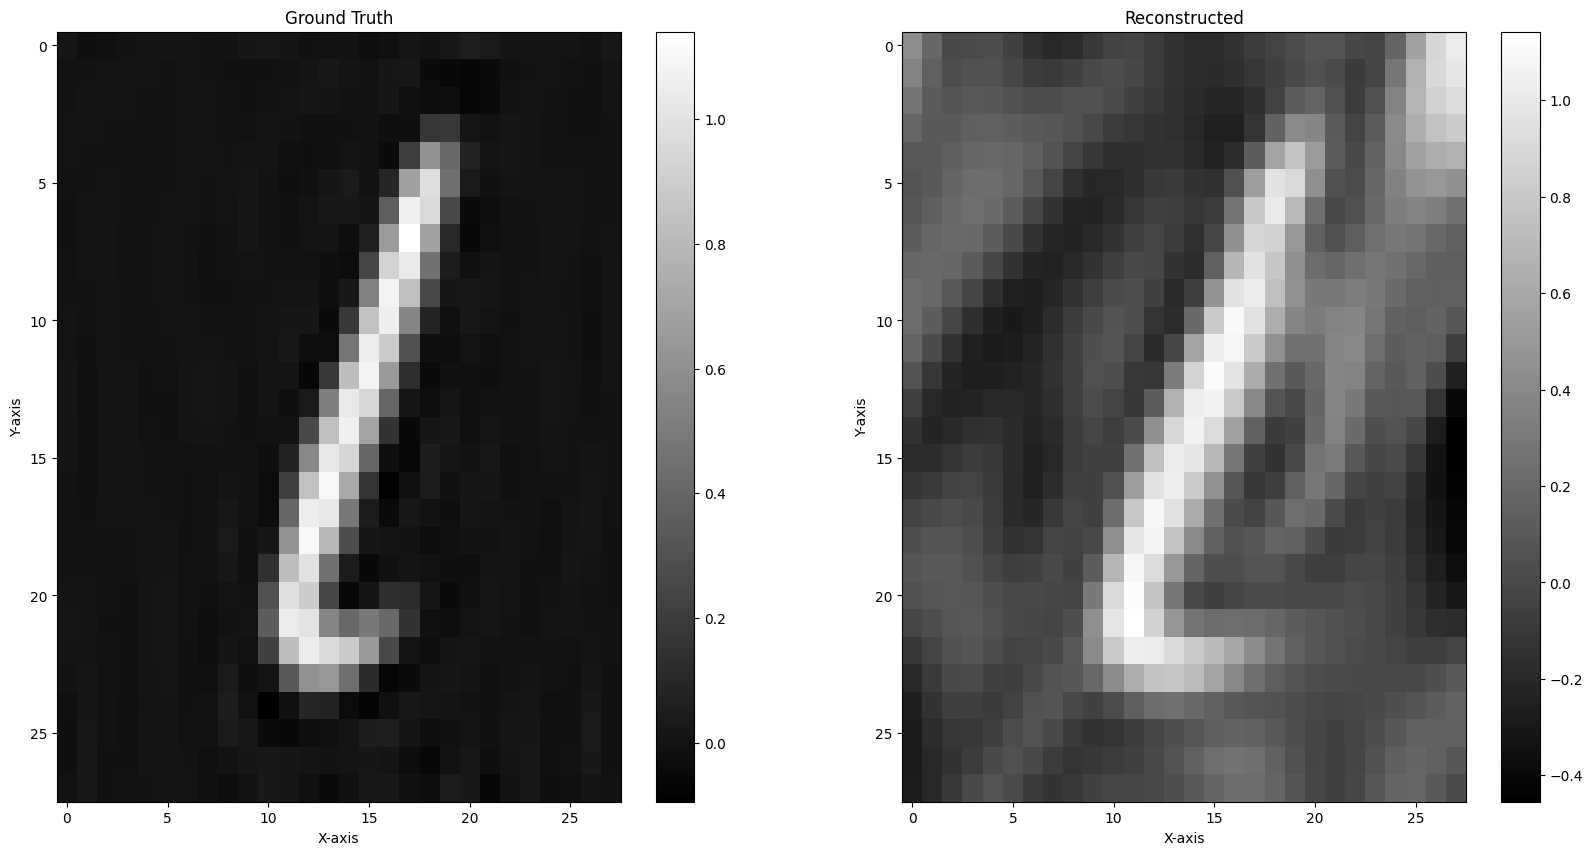

wandb: Network error (ConnectionError), entering retry loop.


In [65]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import OrderedDict
from typing import List, Tuple, Union
from torch import nn
from networks.INR import INR

# Assuming the following classes and functions are defined elsewhere:
# - INR
# - dataset_no_transform
# - ae_trained
# - dataset_flatten


class MinMaxTransformer(nn.Module):
    def __init__(self, min_value: float = -0.3587, max_value: float = 0.4986):
        super().__init__()
        self.min_value = min_value
        self.max_value = max_value

    def forward(self, weights, y):
        # Apply min-max normalization
        weights = (weights - self.min_value) / (self.max_value - self.min_value)
        return weights, y

    def reverse(self, normalized_weights):
        # Reverse the min-max normalization
        original_weights = normalized_weights * (self.max_value - self.min_value) + self.min_value
        return original_weights

def backtransform_weights(flattened_weights, original_weights_dict):
    reconstructed_dict = OrderedDict()
    start = 0
    for key, tensor in original_weights_dict.items():
        num_elements = tensor.numel()
        print(num_elements)
        flattened_slice = flattened_weights[0, start:start + num_elements]
        print(flattened_slice.shape)
        reconstructed_tensor = flattened_slice.view(tensor.shape)
        reconstructed_dict[key] = reconstructed_tensor
        start += num_elements
    return reconstructed_dict

def make_coordinates(
    shape: Union[Tuple[int], List[int]],
    bs: int,
    coord_range: Union[Tuple[int], List[int]] = (-1, 1),
) -> torch.Tensor:
    x_coordinates = np.linspace(coord_range[0], coord_range[1], shape[0])
    y_coordinates = np.linspace(coord_range[0], coord_range[1], shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    coordinates = np.stack([x_coordinates, y_coordinates]).T
    coordinates = np.repeat(coordinates[np.newaxis, ...], bs, axis=0)
    return torch.from_numpy(coordinates).type(torch.float)

# Configuration
inr_kwargs = {"n_layers": 3, "in_dim": 2, "up_scale": 16}
image_size = (28, 28)
idx = 0
# Get dataset elements
dataset_ele = dataset_no_transform[idx][0]
minmax_transformer = MinMaxTransformer(min_value=-0.3587, max_value=0.4986)
dataset_ele_flattened = minmax_transformer.reverse(torch.cat((X[0][0].unsqueeze(0), pred[0])).unsqueeze(0))

# Backtransform weights
reconstructed_dict = backtransform_weights(dataset_ele_flattened, dataset_ele)

# Initialize and load the INR model
inr = INR(**inr_kwargs)
inr.load_state_dict(reconstructed_dict)
inr.eval()

# Generate image using the INR model
input_coords = make_coordinates(image_size, 1)
with torch.no_grad():
    reconstructed_image = inr(input_coords)
    reconstructed_image = reconstructed_image.view(*image_size, -1)
    reconstructed_image = reconstructed_image.permute(2, 0, 1)

reconstructed_tensor = reconstructed_image.squeeze(0)

# Load ground truth model
ground_truth_dict = dataset_ele
ground_truth_inr = INR(**inr_kwargs)
ground_truth_inr.load_state_dict(ground_truth_dict)
ground_truth_inr.eval()

# Generate image using the ground truth model
with torch.no_grad():
    ground_truth_image = ground_truth_inr(input_coords)
    ground_truth_image = ground_truth_image.view(*image_size, -1)
    ground_truth_image = ground_truth_image.permute(2, 0, 1)

ground_truth_tensor = ground_truth_image.squeeze(0)

# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(ground_truth_tensor, cmap='gray', aspect='auto')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

axes[1].imshow(reconstructed_tensor, cmap='gray', aspect='auto')
axes[1].set_title('Reconstructed')
axes[1].set_xlabel('X-axis')
axes[1].set_ylabel('Y-axis')

plt.colorbar(axes[0].imshow(ground_truth_tensor, cmap='gray', aspect='auto'), ax=axes[0])
plt.colorbar(axes[1].imshow(reconstructed_tensor, cmap='gray', aspect='auto'), ax=axes[1])
plt.show()